# How quickly does semantics change

In [1]:
from koselleck import *
FN_DATA_PACEOFCHANGE

'/home/ryan/github/koselleck/data/data.semantic_change_over_decades.1run.v10-local-k50-halfdec.pkl'

In [2]:
DF=pd.read_pickle(FN_DATA_PACEOFCHANGE).reset_index()
DF

,word,dist,neighborhood1,neighborhood2,period1,period2
0,cider,1.447276,"-presbytery, -fund, -brig, -navy, -discharge, ...","+evidence, +homer, +algebra, +tongue, +liquor,...",1720-1725,1725-1730
1,thorn,1.311074,"-bias, -feeling, -song, -clan, -wand, -digesti...","+tumult, +tribunal, +constitution, +senate, +c...",1720-1725,1725-1730
2,remission,1.286927,"-preferment, -support, -authority, -usage, -fu...","+regiment, +troop, +cart, +worsted, +velvet, +...",1720-1725,1725-1730
3,revolt,1.207021,"-diet, -truck, -attack, -receiver, -viceroy, -...","+china, +pot, +storm, +yoke, +bladder, +hurric...",1720-1725,1725-1730
4,lope,1.156108,"-conscience, -heart, -innocence, -passion, -ex...","+twin, +commencement, +collector, +tern, +roan...",1720-1725,1725-1730
...,...,...,...,...,...,...
2935653,sonata,0.006200,"concerto, prelude, andante, symphony, fantasia...","fugue, concerto, adagio, prelude, finale, anda...",1890-1895,1895-1900
2935654,coat,0.006150,"collar, cap, shirt, jacket, nose, waistcoat, n...","waistcoat, collar, cap, shirt, neck, jacket, s...",1890-1895,1895-1900
2935655,sky,0.006044,"cloud, breeze, sunlight, mist, glow, horizon, ...","cloud, sunshine, sun, radiance, breeze, sunlig...",1890-1895,1895-1900
2935656,concerto,0.005469,"sonata, prelude, quintet, overture, symphony, ...","sonata, symphony, quintet, overture, quartet, ...",1890-1895,1895-1900


In [3]:
words=set(DF.word)
len(words)

5982

In [4]:
def do_measure_rateofchange(gdf,**y):
    distdf=get_distmatrix_rateofchange(DF, words=set(gdf.word))
    return test_novelty(distdf,**y)

def measure_rateofchange(idf,lim=None,num_proc=1,**kwargs):
    return pmap_groups(
        do_measure_rateofchange,
        idf.iloc[:lim].groupby('word'),
        num_proc=num_proc,
        desc='Measuring rate of change in all words',
        kwargs=kwargs
    )

In [5]:
# idf=pd.DataFrame([{'word':w} for w in words])
# res=do_measure_rateofchange(idf[idf.word=='culture']).sort_values(
#     'foote_novelty',ascending=False)
# res

In [6]:

FN_NOVELTY_DATA=os.path.join(PATH_DATA,'data.words_by_rateofchange.v4.pkl')
# FN_NOVELTY_DATA=os.path.join(PATH_DATA,FN_DATA_PACEOFCHANGE.replace('.pkl','.novelty-measured.pkl'))
def get_novelty_data(ifn=FN_NOVELTY_DATA,num_proc=4,words=words):
    #gen/load
    if not os.path.exists(ifn):
        idf=pd.DataFrame([{'word':w} for w in words])
        allres=measure_rateofchange(idf,lim=None,num_proc=num_proc)
        allres.to_pickle(ifn)
    else:
        allres = pd.read_pickle(ifn)
    
    # filter
    allres = allres.query('foote_novelty!=0')
    allres['is_signif']=[int(x<0.05)# or y<0.01)
                        for x,y in zip(allres.p_peak,allres.p_trough)]
    allres['foote_size']=allres.foote_size.apply(int)
    allres['year']=allres.year.apply(int)
    allres = pd.concat(grp.assign(glen=len(grp)) for i,grp in allres.groupby(['foote_size','year'])).reset_index()
    allres = pd.concat(
        grp.sort_values('year').assign(
            foote_novelty_z=((grp.foote_novelty - grp.foote_novelty.dropna().mean()) / grp.foote_novelty.dropna().std())
        )#.set_index('year').rolling(rolling,min_periods=min_periods).mean()
        for i,grp in allres.groupby('foote_size')
    )
    return allres

In [7]:
allres=get_novelty_data(num_proc=6)
allres

,word,year,foote_novelty,foote_size,p_peak,p_trough,is_signif,glen,foote_novelty_z
0,abbe,1730,1.201551,2,0.52,1.00,0,3323,1.768272
2210,pit,1730,1.012427,2,0.46,1.00,0,3323,1.317744
2211,pitch,1730,1.011627,2,0.90,1.00,0,3323,1.315838
2212,pith,1730,1.908225,2,0.98,1.00,0,3323,3.451695
2213,pity,1730,0.961692,2,0.01,1.00,1,3323,1.196885
...,...,...,...,...,...,...,...,...,...
681595,exhaustion,1865,1.492409,6,1.00,0.19,0,5150,-0.436032
681594,exhaust,1865,7.483163,6,0.37,1.00,0,5150,2.370555
681593,exertion,1865,1.658596,6,1.00,1.00,0,5150,-0.358176
681651,familiarity,1865,0.957187,6,1.00,1.00,0,5150,-0.686776


In [8]:
# allres[allres.word=='culture'].sort_values('foote_novelty',ascending=False).query('4<=foote_size<=6')

In [9]:
def get_novelty_classes(val='p_peak'):
    calld={}
    for w,wdf in allres.groupby('word'):
        if any(x<.001 for x in wdf[val]):
            calld[w]='Novelty+++'
        if any(x<.01 for x in wdf[val]):
            calld[w]='Novelty++'
        if any(x<.05 for x in wdf[val]):
            calld[w]='Novelty+'
        else:
            calld[w]=''
    return pd.Series(calld)

In [10]:
call=get_novelty_classes()
allres=allres.set_index('word')
allres['call']=get_novelty_classes()
allres=allres.reset_index()

In [11]:
allres[(allres.call=='Novelty+') & (allres.foote_size==6)].groupby('word').mean().sort_values('foote_novelty',ascending=False)

,year,foote_novelty,foote_size,p_peak,p_trough,is_signif,glen,foote_novelty_z
word,,,,,,,,
slate,1807.500000,15.918840,6.0,0.762500,0.787500,0.166667,4733.791667,6.322554
sort,1807.500000,15.888724,6.0,0.687917,0.769167,0.250000,4733.791667,6.308445
muff,1801.052632,15.385834,6.0,0.706316,0.845263,0.210526,4638.684211,6.072848
mutt,1793.055556,15.001900,6.0,0.717778,0.697778,0.222222,4538.777778,5.892980
fee,1807.500000,14.560880,6.0,0.770833,0.629167,0.166667,4733.791667,5.686368
...,...,...,...,...,...,...,...,...
rock,1807.500000,0.638664,6.0,0.962083,0.797500,0.000000,4733.791667,-0.836000
window,1807.500000,0.637417,6.0,0.943333,0.809167,0.000000,4733.791667,-0.836584
bosom,1807.500000,0.600283,6.0,0.972500,0.556667,0.000000,4733.791667,-0.853981


In [12]:
vsign=allres[allres.p_peak<0.01]
vsign.word.value_counts()
# vsign

sort      12
trait     12
fame      12
room      11
fee       11
          ..
harp       1
budget     1
mailer     1
ping       1
wick       1
Name: word, Length: 1041, dtype: int64

In [13]:


def get_figdf(vsign,rolling=2,min_periods=1,foote_sizes={3,4,5},gby=['foote_size','year']):
#     figdf_mean=vsign.groupby(['foote_size','year']).mean().reset_index()
#     figdf_mean=figdf_mean[~figdf_mean.foote_novelty.isna()]
    figdf_mean = pd.concat(grp.assign(glen=len(grp)) for i,grp in vsign.groupby(gby))
    figdf_mean = figdf_mean.groupby(gby).mean().reset_index()
    if rolling>1:
        figdf_mean = pd.concat(
            grp.set_index(
                gby+['is_signif'],
            ).sort_index().rolling(
                rolling,
                min_periods=min_periods
            ).mean().reset_index()
            for i,grp in figdf_mean.groupby(gby[:-1])
        ).reset_index()
    figdf_mean['year_window']=figdf_mean['foote_size']*5*2
    return figdf_mean.dropna()#.groupby(['year','foote_size']).mean().reset_index(z)

In [14]:
get_figdf(vsign)#,gby=['foote_size','word','year'],rolling=2,min_periods=1)

,index,foote_size,year,is_signif,foote_novelty,p_peak,p_trough,glen,foote_novelty_z,year_window
0,0,2,1730,1,2.335893,0.0,1.0,53.0,4.470476,20
1,1,2,1735,1,2.680527,0.0,1.0,33.0,5.291454,20
2,2,2,1740,1,2.815634,0.0,1.0,7.5,5.613303,20
3,3,2,1745,1,2.807151,0.0,1.0,4.0,5.593096,20
4,4,2,1750,1,2.716132,0.0,1.0,6.5,5.376271,20
...,...,...,...,...,...,...,...,...,...,...
130,19,6,1845,1,10.013068,0.0,1.0,19.0,3.555781,60
131,20,6,1850,1,10.576365,0.0,1.0,15.5,3.819677,60
132,21,6,1855,1,11.141237,0.0,1.0,15.5,4.084312,60
133,22,6,1860,1,10.752690,0.0,1.0,18.5,3.902283,60


In [15]:
def plot_distmat(distdf,xcol='period_int1',ycol='period_int2',value_name='value',use_color=False,xlim=None,ylim=None,**y):
    ddf=distdf
    
    
    distdfm=distdf.reset_index().melt(id_vars=[xcol],value_name=value_name).dropna()
#     display(distdfm)
    
    fig=start_fig(
        distdfm,
        x=f'factor({xcol})',
        y=f'factor({ycol})',
        fill=value_name,
        **y
    )
    fig+=p9.geom_tile()
    if not use_color:
        fig+=p9.scale_fill_gradient(low='#111111',high='#FFFFFF')   
    else:
        fig+=p9.scale_fill_distiller(type='div',palette=5)
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90))
    return fig

In [16]:
@interact
def showdist(w='culture'):
    distdf=get_distmatrix_rateofchange(DF,words=set(wx.strip() for wx in w.split(',')))
    return plot_distmat(distdf,use_color=False,figure_size=(8,8))

interactive(children=(Text(value='culture', description='w'), Output()), _dom_classes=('widget-interact',))

In [17]:
# @interact
def show(
        allres=allres,
    
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=0.01,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width in years',
        shapelab='Foote matrix width in years',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1720,
        xlim1=1970,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=0.1,
        ymin_heatmap=1750,
        combine=True,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        words='',
        ):

    figdf=allres.query(f'{min_foote_size}<=foote_size<={max_foote_size}')
    if words:
        words=set(tokenize_fast(words))
        figdf=figdf[figdf.word.isin(words)]
        gby=['word','year','foote_size']
        figdf=figdf.groupby(gby).mean().reset_index()
#         display(figdf)
    else:
        gby=['foote_size','year']
    if max_p_peak:
        figdf=figdf[figdf.p_peak<max_p_peak]
    if not len(figdf): return
    figwords=set(figdf.word)
    if 'significant words' in title:
        title=title.replace('significant words',f'significant (p<{round(max_p_peak,2)}) words')
    
    
    figdf=get_figdf(figdf,
        rolling=rolling,
        min_periods=min_periods,
        foote_sizes=set(range(min_foote_size,max_foote_size+1)),
        gby=gby
    )
    figdf['is_signif']=[bool(x>0) for x in figdf.is_signif]
    
    figdf=figdf.sort_values('year')
#     display(figdf)
    if showdata: display(figdf)
#     print(f'y = {y}')
    fig=start_fig(
        figdf,
        x='year',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
#         {
#             'yintercept':0,
#             kname:'Zero novelty'
#         }
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
        fig+=p9.geom_text(inherit_aes=False,y=figdf[y].median()+.1,x=xlab_min,size=6,alpha=.8,ha='center',label='Median')
    
    
    fig+=p9.geom_line()
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    # fig+=p9.geom_smooth()
#     fig+=p9.scale_color_distiller()
    fig+=p9.geom_vline(xintercept=1770,linetype='dashed') 
    fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1848,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    
    
#     fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
#     fig+=p9.xlim(xlim0,xlim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
#     fig+=p9.geom_smooth(p9.aes(x='year',y=y),inherit_aes=False)

    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',size=6,data=labeldf,boxcolor=(0,0,0,0.5))
        
    fig+=p9.geom_label(label='Sattelzeit begins (1870)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    fig+=p9.geom_label(label='French Rev. (1789)',x=1790+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    fig+=p9.geom_label(label='Peak semantic change (1815)',x=1815+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    fig+=p9.geom_label(label='Revolutions of 1848',x=1848+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    
    

#     xlim0,xlim1=figdf.year.min()//10*10,figdf.year.max()
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
#     fig+=p9.scale_x_continuous(breaks=10)
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90))
    
        
    
    
    
    #fig+=p9.scale_fill_gray()
#     fig+=p9.scale_x_continuous(
# #         minor_breaks=list(range(xlim0//10*10,(xlim1//10*10)+10,10)),
#         limits=[xlim0,xlim1]
#     )
#     fig+=p9.xlim(xlim0,xlim1)
    
    if combine:

        yymin1=figdf.year.min()
        yymax1=figdf.year.max()
        if ymin_heatmap:
            pass
#             fig+=p9.xlim(ymin_heatmap,yymax1)
        else:
            ymin_heatmap=figdf.year.min()
        distdf=get_distmatrix_rateofchange(DF, words=figwords,ymin=ymin_heatmap)#, ymax=figdf.year.max())
        figdm=plot_distmat(distdf,figure_size=(8,h_fig2),use_color=use_color)
        figdm+=p9.labs(
            fill='Semantic distance',
            x='Date of semantic model',y='Date of semantic model'
        )
        fig1,fig2=fig,figdm
    wkey='-'.join(words) if words else ''
    if save:
        ofn=f'''fig.foote_novelty_over_time.{y}.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
        ofnfn=os.path.join(PATH_FIGS,ofn)
        if combine:
            display(combine_plots(fig1,fig2,ofn=ofnfn))
        else:
            fig.save(ofnfn)
            #fig.save(f'/home/ryan/Markdown/Drafts/TheGreatAbstraction/figures/{ofn}')
        shutil.copyfile(ofnfn,f'/home/ryan/Markdown/Drafts/TheGreatAbstraction/figures/{ofn}')
    else:
        if combine:
            display(combine_plots(fig1,fig2))
        else:
            display(fig)
#             display(figdm)
    
#     return figdf



## All words

In [18]:
# figdf=allres
# #[~allres.word.str.contains('s')]
# res=interact_manual(
#     show,
#     allres=fixed(figdf),
#     y=['foote_novelty_z','foote_novelty','foote_novelty_z2'],
#     vnum='v18',
#     ylim1=5.5,
#     ymin=1.4,
#     ylim0=1.5,
#     use_ylim=False,
#     max_p_peak=0.05,
# #     ymin=1.5,
#     min_foote_size=4,
#     max_foote_size=6,
#     save=False,
#     rolling=1,
#     hline=fixed('')
# )

In [19]:
# allres.foote_

In [20]:
# figdf=allres.query('4<=foote_size<=6')
# #[~allres.word.str.contains('s')]
# show(
#     allres=figdf,
#     y='foote_novelty_z',
#     vnum='v18',
#     size='is_signif',
#     words='culture',
#     use_ylim=0,
#     max_p_peak=0,
#     title='Novelty scores for "culture"',
#     min_foote_size=4,
#     max_foote_size=6,
#     save=False,
#     rolling=1
# )

In [21]:
figdf=allres.query('4<=foote_size<=6')
# #[~allres.word.str.contains('s')]
# show(
#     allres=figdf,
#     y='foote_novelty_z',
#     vnum='v18',
#     size='is_signif',
#     words='culture',
#     use_ylim=0,
#     max_p_peak=0,
#     title='Novelty scores for "culture"',
#     min_foote_size=4,
#     max_foote_size=6,
#     save=False,
#     rolling=1
# )

In [22]:
# res=interact_manual(
#     show,
#     allres=fixed(allres),
#     y=['foote_novelty','foote_novelty_z'],
# #     words='citizen,condition,slavery,train,revolution',
# #     words='citizen,revolution,slave,train,reform,demand',
# #     words='citizen,reform,demand,slavery,train',
#     words='culture',
#     color='word',
#     group='word',
#     shape='word',
#     colorlab='Word',
#     shapelab='Word',
#     sizelab='Statistically significant',
#     title='Novelty scores for key words',
#     ylab='Foote Novelty score',
#     size='is_signif',
#     vnum='v18',
#     ylim1=10,
#     ylim0=0,
#     use_ylim=True,
#     add_median=True,
#     max_p_peak=0.0,
#     rolling=1,
#     ymin=-.1,
#     min_foote_size=6,
#     max_foote_size=6,
#     nudge_label_y=.4,
#     showdata=False
# )


In [23]:
def show_word_novelty(words='',**kwargs):
    inpd=dict(
        y='foote_novelty',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v18',
        ylim1=10,
        ylim0=0,
        use_ylim=True,
        add_median=True,
        max_p_peak=0.0,
        rolling=1,
        ymin=-.1,
        min_foote_size=6,
        max_foote_size=6,
        nudge_label_y=.4,
        showdata=False
    )
    return show(**{**inpd, **kwargs})


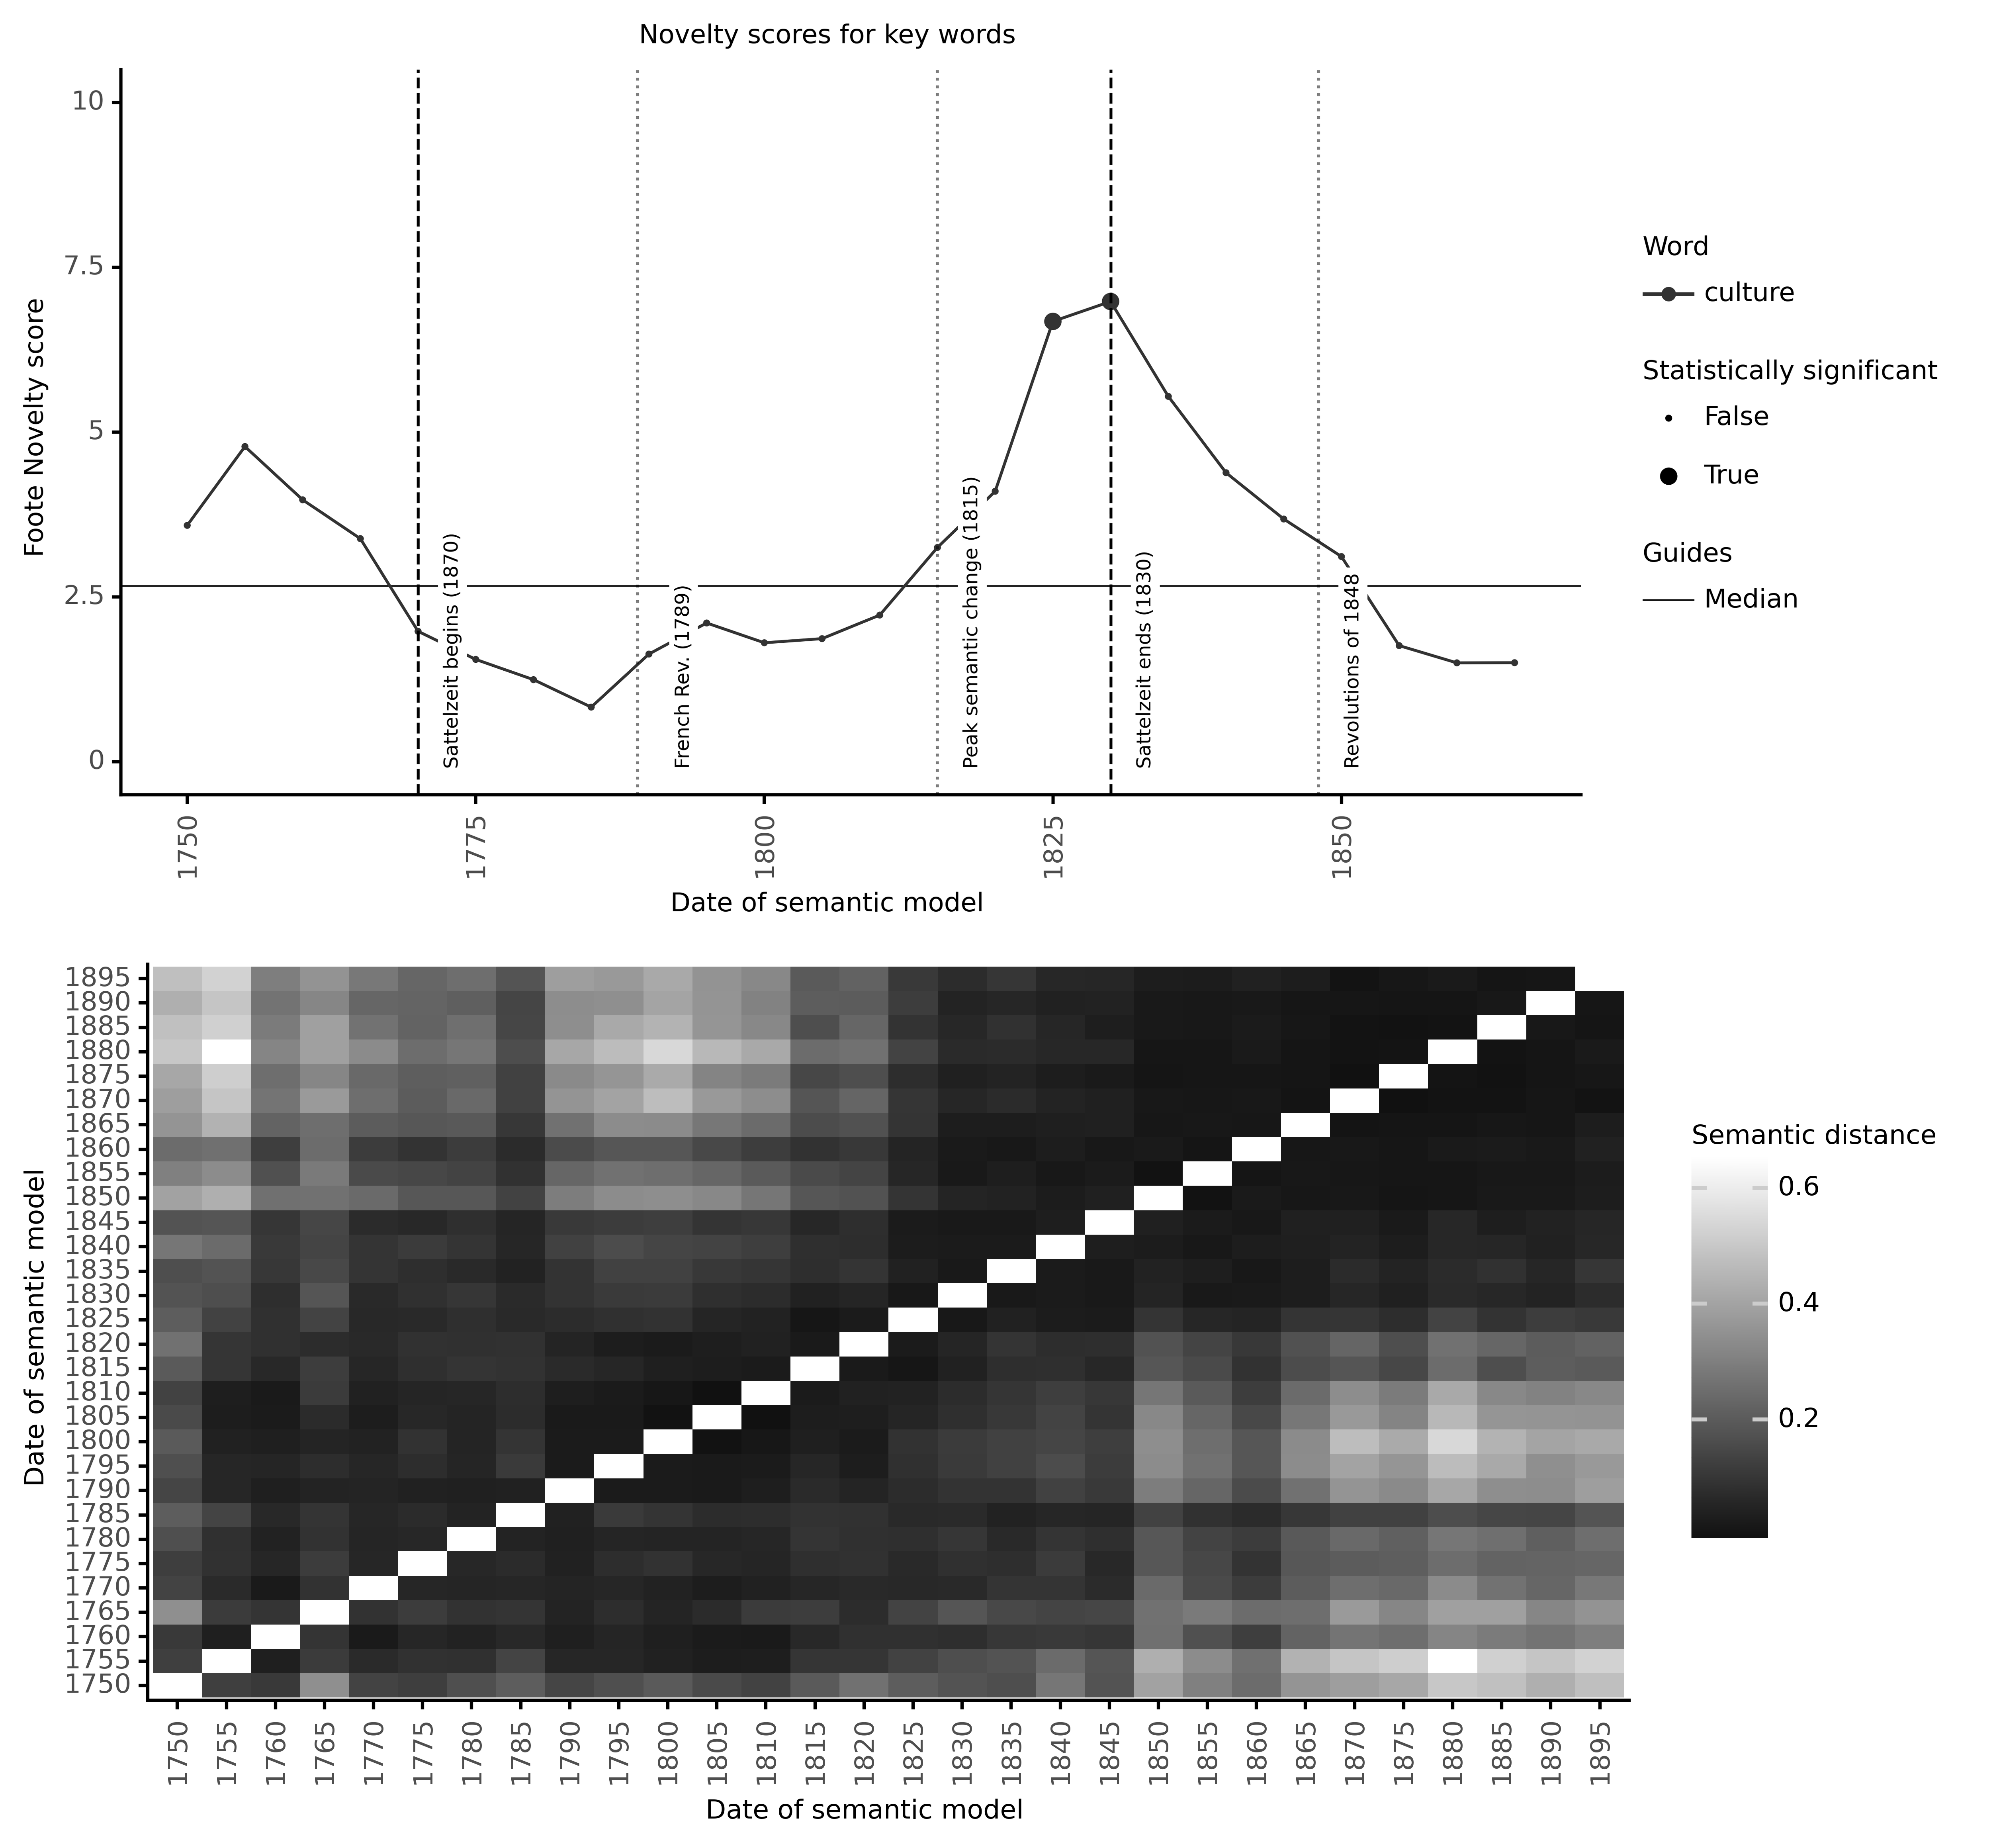

In [24]:
show_word_novelty('culture',ylim1=10)

In [25]:
# solo_res=interact_manual(
#     show,
#     allres=fixed(allres),
#     words='culture',
#     color='word',
#     group='word',
#     shape='word',
#     colorlab='Word',
#     shapelab='Word',
#     sizelab='Statistically significant',
#     title='Novelty scores for key words',
#     size='is_signif',
#     vnum='v16-keywords-solo',
#     y='foote_novelty',
#     ylim0=0,
#     ymin=-.1,
#     ylim1=7,
# #     xlim0=1720,
# #     xlim1=1970,
#     use_ylim=True,
#     max_p_peak=0.0,
#     rolling=1,
#     min_foote_size=6,
#     max_foote_size=6,
#     nudge_label_y=.4,
#     nudge_x=2
# )


## Most novel words

In [26]:
# # allres['_num']=1.0
# qdf=allres.query('1800<=year<1870 & foote_size==6 & p_peak<0.01')
# qdf=pd.concat(
#     grp.assign(glen2=len(grp))
#     for i,grp in qdf.groupby('word')
# #     if len(grp)>1
# )
# qdf=qdf.groupby('word').mean().sort_values('foote_novelty',ascending=False)

# # filter?
# qdf=qdf.loc[[x for x in qdf.index if not 'f' in x and not 's' in x]]
# # qdf

In [27]:
# for n in range(4):
#     printm(f'## {n+1}')
#     display(qdf.iloc[n*25: (n+1)*25])

In [31]:
def show_mostnovel_df(querystr=''):
    dfc=get_dfchange()
    cleanwords=set(dfc[dfc.is_clean_noiseaware==True].index)
    lo=[]
    figdf=allres.query('6<=foote_size<=6 & p_peak<0.05')
    #.groupby(['year','word']).mean().reset_index()
#     figdf=figdf[figdf.word.isin(get_words_ever_abs())]
    for i,grp in figdf.groupby('year'):
        grp=grp.drop_duplicates('word').sort_values('foote_novelty',ascending=False)
        words=', '.join(
            f'{w} ({round(z,1)})'
            for w,z in zip(grp.word,grp.foote_novelty)
            if 's' not in w and 'f' not in w and w in cleanwords
        )
        lo+=[{'period':int(i), 'words':words}]
    odf=pd.DataFrame(lo)
    if querystr: odf=odf.query(querystr)
    printm(odf.set_index('period').to_markdown())

#res=interact_manual(show_mostnovel_df)
show_mostnovel_df()#'1760<=period<=1900')

|   period | words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     1750 | price (26.2), tumult (21.0), entertainment (21.0), diet (20.0), parade (19.3), arch (18.7), cone (17.0), adventure (15.4), citizen (15.0), recovery (14.7), commencement (13.9), admiration (13.3), morrow (13.2), convenience (13.2), miracle (12.9), hint (12.8), calling (12.5), opening (11.8), angel (11.6), malignity (11.6), juncture (11.3), recommendation (11.1), eminence (10.9), conveyance (10.8), unity (10.7), lime (10.6), bounty (10.4), participation (10.3), experiment (10.2), compliment (10.1), turnpike (10.1), venture (10.0), globe (9.7), ether (9.6), herring (9.5), moment (9.5), laird (9.5), margin (9.4), tutor (9.3), company (9.2), melancholy (9.1), avail (9.0), combat (9.0), mint (9.0), itch (8.9), coinage (8.8), trouble (8.4), duck (8.2), end (8.1), way (8.1), dung (8.1), acid (7.7), hearing (7.6), remedy (7.6), captivity (7.6), voyage (7.5), borrowing (7.5), eternity (7.4), appellation (7.4), traitor (7.4), painter (7.4), tick (7.3), monk (7.2), table (7.2), mediation (7.2), mantle (7.1), body (7.1), root (7.1), printer (7.0), bile (7.0), care (7.0), attic (6.9), nun (6.9), partner (6.8), amazement (6.8), invitation (6.6), neighbourhood (6.6), pearl (6.6), tongue (6.6), loo (6.5), journey (6.4), appetite (6.4), crying (6.3), novelty (6.3), detriment (6.2), galley (6.2), mead (6.2), devotion (6.2), track (6.1), brook (6.1), manner (6.1), map (6.0), roper (6.0), vehemence (6.0), agriculture (6.0), height (5.9), abbot (5.9), departure (5.9), pin (5.9), value (5.9), pocket (5.9), alliance (5.9), plate (5.8), emperor (5.8), point (5.8), tort (5.8), pine (5.7), weight (5.7), age (5.7), lark (5.6), decay (5.6), oke (5.6), print (5.6), breath (5.6), commander (5.6), admirer (5.6), egg (5.5), marriage (5.4), canal (5.4), valet (5.4), vivacity (5.4), market (5.4), churchyard (5.4), acre (5.3), heap (5.3), labour (5.2), chronicle (5.1), girl (5.1), week (5.1), place (5.0), bom (5.0), canon (5.0), wind (5.0), navigation (4.9), woman (4.9), dove (4.9), guard (4.9), treaty (4.8), people (4.8), church (4.7), expedition (4.6), humour (4.6), pain (4.6), cel (4.5), robe (4.4), degree (4.4), country (4.3), wheat (4.3), pillar (4.3), quantity (4.3), weather (4.2), wheel (4.2), ridge (4.1), aunt (4.1), kind (4.1), ring (4.0), doubt (4.0), prejudice (4.0), bed (3.9), torrent (3.9), leap (3.9), gate (3.8), noon (3.8), light (3.8), contrary (3.8), vegetable (3.7), bay (3.7), gal (3.7), depth (3.6), phi (3.5), uncle (3.5), bra (3.5), day (3.5), cedar (3.5), juice (3.4), countenance (3.4), night (3.4), corruption (3.4), lock (3.3), arrival (3.3), variety (3.3), mother (3.3), tail (3.2), painting (3.2), reader (3.2), port (3.2), vault (3.2), colour (3.2), rain (3.2), volume (3.1), opportunity (3.1), merit (3.1), child (3.1), road (3.1), dit (3.1), bridge (3.0), harbour (3.0), kitchen (3.0), enjoyment (2.9), coal (2.9), lady (2.9), behaviour (2.9), world (2.9), edition (2.7), water (2.7), dowager (2.7), cellar (2.7), coach (2.7), collection (2.6), index (2.6), brick (2.6), literature (2.6), leg (2.6), metal (2.5), brother (2.5), poem (2.4), dean (2.4), morning (2.4), iron (2.3), daughter (2.2), duke (2.1), indignation (2.1), temper (1.7) |
|     1755 | citizen (21.9), price (20.8), parade (18.2), entertainment (17.2), recovery (16.1), tumult (14.9), correction (13.0), commencement (12.2), renewal (11.4), cure (10.9), convenience (10.7), venture (10.3), avail (10.1), conveyance (9.9), melancholy (9.6), malignity (9.6), way (9.3), admiration (9.3), unity (8.9), dole (8.6), table (8.4), margin (8.2), preamble (8.1), emotion (8.1), connexion (7.9), remedy (7.8), itch (7.8), palate (7.7), duck (7.5), agony (7.3), trouble (7.2), agreement (6.7), printer (6.6), appetite (6.6), injury (6.4), acre (6.2), mead (6.2), beach (6.1), agriculture (6.1), dagger (6.1), detriment (6.0), guile (5.9), pearl (5.8), root (5.7), loo (5.4), value (5.2), anxiety (5.2), decay (5.2), emperor (5.2), pocket (5.1), warmth (5.1), week (5.0), aurora (4.9), chalk (4.9), angle (4.6), greyhound (4.5), dove (4.5), howl (4.4), commander (4.0), tad (4.0), cel (3.8), buck (3.8), vivacity (3.7), prejudice (3.6), phi (3.3), opportunity (3.1), lord (3.1), gate (3.1), night (2.9), merit (2.8), brother (2.6), lady (2.5), edition (2.4), morning (2.2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|     1760 | challenge (22.0), citizen (21.4), recovery (14.5), lava (14.0), adventure (13.6), legion (13.5), imbecility (13.3), expert (13.3), cure (11.5), prayer (11.2), unity (10.8), game (10.7), lending (10.5), diadem (10.1), renewal (9.7), dole (9.4), admiration (9.3), avail (9.3), melancholy (8.7), table (8.6), way (8.5), connexion (8.4), remedy (8.3), accomplice (8.1), commonwealth (7.7), palate (7.7), reply (7.4), ruby (7.2), invitation (6.9), agony (6.7), loo (5.9), bullion (5.9), emotion (5.8), hunter (5.4), decay (4.9), anxiety (4.9), root (4.7), debate (4.7), danger (4.6), dove (4.5), pocket (4.5), apology (4.5), guard (4.4), commander (4.0), tad (3.8), attempt (3.8), pudding (3.8), jury (3.4), prejudice (3.3), opportunity (3.1), capacity (2.4)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|     1765 | citizen (17.7), expert (14.3), game (12.4), renewal (11.9), theta (10.8), accomplice (10.5), cure (9.9), prayer (9.9), rink (9.8), lava (9.7), monopoly (9.1), cologne (7.8), connexion (7.2), equality (6.5), interview (5.5), leopard (5.5), greyhound (5.3), anarchy (5.2), blood (4.9), hawk (4.7), attempt (4.7), debate (4.6), apology (4.5), peace (4.0), prejudice (3.8), danger (3.7), advantage (2.6)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
|     1770 | judgement (15.0), prayer (11.5), bargain (11.5), motion (10.6), renewal (10.4), minute (10.1), game (9.4), complaint (9.3), lava (8.9), loading (8.4), dole (7.9), magnitude (7.5), load (6.9), blood (6.8), mole (6.4), executive (6.2), crow (5.7), cowardice (5.6), pennant (5.5), anarchy (4.9), greyhound (4.5), murder (4.4), queen (4.3), attempt (4.0), tooth (3.9), navy (3.5), jury (3.4), prejudice (3.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|     1775 | moving (21.8), zinc (15.3), accord (14.5), intent (12.8), impudence (11.3), bargain (10.9), prayer (10.8), judgement (10.5), vacancy (10.5), barrack (9.9), motion (9.6), complaint (9.3), term (7.8), blood (7.1), magnitude (6.9), commendation (6.3), democracy (5.4), delineation (5.3), executive (5.3), context (5.2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
|     1780 | moving (24.8), evacuation (15.0), zinc (13.2), bail (12.0), trait (11.5), bargain (11.5), intent (10.9), impudence (9.7), coalition (9.4), threat (9.1), prayer (8.6), job (7.3), tribunal (6.8), wit (5.8), cough (5.6), democracy (5.2), context (4.9), blood (4.9), bullet (4.2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
|     1785 | trait (19.0), miracle (11.4), oracle (10.9), decree (10.2), zinc (9.6), bail (8.5), bouquet (7.9), tilth (7.5), privation (6.6), cough (6.0), wit (5.6)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|     1790 | hare (26.3), trait (13.9), decree (11.4), oracle (10.6), nabob (10.3), lobby (9.1), reek (8.5), coalition (8.1), term (8.0), peat (7.8), bouquet (7.4), peal (6.3), cough (5.9), accumulation (4.7)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
|     1795 | hare (37.6), trait (12.8), ending (11.7), gig (9.0), reek (8.8), demand (8.4), nod (7.9), breeding (7.6), peat (7.5), bile (7.2), creed (7.2), troth (6.8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
|     1800 | hare (33.0), greeting (11.9), demand (10.4), gig (9.4), bankruptcy (9.1), nod (8.8), creed (7.7), hook (7.7), bouquet (7.4), reek (7.3), accumulation (4.6), lace (4.2), cornice (2.9)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|     1805 | hare (25.0), labourer (12.2), guide (11.6), greeting (9.8), hook (9.1), gig (7.7), demand (7.3), clemency (7.3), creed (6.8), pope (6.2), vole (5.6), baud (5.4)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|     1810 | urge (14.8), labourer (12.8), gout (11.5), guide (11.4), greeting (11.3), twill (10.4), hook (9.8), injunction (9.2), champagne (8.6), retention (7.7), tilth (7.2), martyrdom (7.2), chili (7.1), hypocrite (7.0), leech (6.7), mule (6.1), abbe (5.8), vole (5.8), exaggeration (5.6), church (3.8), cornice (3.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|     1815 | tinder (17.9), labourer (15.3), urge (13.7), guide (13.1), vehicle (12.0), negro (11.9), moat (11.5), gout (9.7), mercury (9.4), hook (9.3), vacation (8.5), heretic (8.4), champagne (7.9), portal (7.9), theatre (7.8), martyrdom (7.6), patriot (7.5), comedy (7.4), ordination (7.2), toilette (6.3), exaggeration (6.1), loathing (4.7), archdeacon (2.1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|     1820 | moat (15.5), negro (14.6), vagrant (14.5), urge (13.3), vehicle (11.6), auto (11.4), gaming (11.1), exam (10.5), heretic (10.5), vocation (10.2), recreation (10.1), champagne (8.6), ordination (7.1), hook (6.9), comedy (6.9), tart (6.3), exaggeration (5.8), toilette (5.4), peace (4.0), cat (3.6)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|     1825 | ledge (23.7), meantime (18.4), hitter (12.4), vehicle (12.0), honor (11.7), vocation (9.9), recreation (9.1), rabbi (8.5), patriot (7.7), ordination (7.2), intervention (7.0), liver (6.9), rib (6.0), exaggeration (5.7), abbe (5.7), toil (4.4), monday (3.5)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|     1830 | boon (24.1), ledge (24.0), vehicle (12.7), honor (11.5), vocation (10.3), racing (8.7), canto (8.0), intervention (6.6), rib (6.2), penny (5.5), linen (4.4), toil (4.0), anecdote (2.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|     1835 | ledge (29.2), boon (24.7), aim (10.6), bane (7.1), drawback (6.9), intervention (6.2), cornet (5.7), rib (5.2), toil (4.0), example (4.0), baker (2.7), anecdote (2.1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|     1840 | ledge (26.4), device (12.3), viewing (11.4), aim (9.6), whim (8.7), papacy (8.6), trench (8.0), retirement (7.1), ping (6.6), tabernacle (6.5), bane (6.1), mamma (5.6), epilogue (5.3), anecdote (2.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|     1845 | mark (9.6), whim (8.6), deceit (8.1), anticipation (7.4), retirement (6.3), gardening (6.2), pencil (5.3), epilogue (5.2), array (4.7), corn (4.7), merchant (4.6), dock (4.0), abhorrence (4.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|     1850 | pallor (18.0), caprice (13.8), dating (13.3), buckle (12.6), caution (11.2), rite (9.5), habitation (8.3), mechanic (7.0), corn (6.7), gardening (6.0), coke (5.8), inauguration (5.3), pic (5.2), pencil (4.5), abhorrence (4.4), melting (3.7)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|     1855 | caprice (13.9), pallor (13.6), buckle (13.2), caution (12.9), volunteer (12.5), rite (11.1), generality (8.9), interment (6.9), metaphor (6.3), gardening (6.0), coke (5.8), meridian (5.7), corn (5.4), balcony (5.1), pencil (4.9)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
|     1860 | annex (15.9), role (12.2), gaiety (11.2), domain (10.7), generality (9.1), meridian (6.6), pew (6.3), curate (5.2), pencil (5.0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|     1865 | contention (15.9), gaiety (15.0), greed (15.0), workman (12.4), role (11.7), criterion (11.6), jew (11.5), diligence (11.4), minute (10.0), pew (6.1), ego (5.5), emulation (5.1), erudition (3.8)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |